In [1]:
import pandas as pd
from sklearn.metrics import ndcg_score
import numpy as np

In [2]:
unames = ['user_id', 'gender', 'age', 'occupation', 'zip']
users = pd.read_table('../../data/ml-1m/users.dat', sep='::', header=None, names=unames, engine='python')

rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_table('../../data/ml-1m/ratings.dat', sep='::',header=None, names=rnames, engine='python')

mnames = ['movie_id', 'title', 'genres']
movies = pd.read_table('../../data/ml-1m/movies.dat', sep='::',header=None, names=mnames, engine='python',encoding='latin-1')

## Random Recommender

In [44]:
def get_random_recommendations(users,movies,k=10):
    recommendations = {}
    for user_id in users.user_id:
        recommendations[user_id] = movies.sample(n=k)['movie_id'].values
    return recommendations
    

## Popularity-based Recommender (recommend movies with most ratings)

In [13]:
def get_popular_recommendations(train_ratings, movies, k=10):
    # Get the top k most rated movies
    top_k_movies = train_ratings.groupby('movie_id').size().sort_values(ascending=False).head(k).index.to_numpy()
    
    return {user_id: top_k_movies for user_id in train_ratings.user_id.unique()}

## Recommeding with highest rating

In [19]:
def calculate_rating_for_movie(df):
    if df.shape[0] < 50:
        return 0
    return df.mean()

def get_top_rated_recommendations(train_ratings, movies, k=10):
    top_movies = train_ratings.groupby('movie_id')['rating'].aggregate(calculate_rating_for_movie).sort_values(ascending=False)[:k].index.to_numpy()
    
    return {user_id: top_movies for user_id in train_ratings.user_id.unique()}


## Weighted Random

In [37]:
def calculate_rating_for_movie(df):
    if df.shape[0] < 20:
        if df.mean() >= 3:
            return 3
        return 2
    return df.mean()

def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / exp_x.sum()

def get_weighted_random(train_ratings, movies, k=10):
    movie_ratings = train_ratings.groupby('movie_id')['rating'].aggregate(calculate_rating_for_movie)
    movie_probability = softmax(movie_ratings)
    recommendations = {}
    for user_id in train_ratings.user_id.unique():
        recommendations[user_id] = np.random.choice(movie_ratings.index, size=k, replace=False, p=movie_probability)
    
    return recommendations


## Evaluating 


For evaluating we will firstly define metrics, then we will split data in different ways and measure how good this methods work.

In [53]:
def precision_recall_at_k(recommendations, test_ratings, k=5):
    precisions = []
    recalls = []
    
    for user_id, recs in recommendations.items():
        # Get the test set for this user
        relevant_items = test_ratings[test_ratings.user_id == user_id].movie_id.values
        
        # Calculate precision
        top_k_recs = recs[:k]
        num_relevant_items = sum(item in relevant_items for item in top_k_recs)
        
        precision = num_relevant_items / k
        recall = num_relevant_items / len(relevant_items) if len(relevant_items) > 0 else 0
        
        precisions.append(precision)
        recalls.append(recall)
    
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    
    return avg_precision, avg_recall

def ndcg_at_k(recommendations, test_ratings, k=5):
    all_ndcgs = []
    
    for user_id, recs in recommendations.items():
        # Get the test set for this user
        relevant_items = test_ratings[test_ratings.user_id == user_id].movie_id.values
        
        # Create relevance scores
        relevance = np.isin(recs[:k], relevant_items).astype(int)
        
        # Calculate NDCG
        ideal_relevance = np.sort(relevance)[::-1]
        if np.sum(ideal_relevance) > 0:
            ndcg = ndcg_score([ideal_relevance], [relevance], k=k)
            all_ndcgs.append(ndcg)
    
    return np.mean(all_ndcgs)

def mean_average_precision_at_k(recommendations, test_ratings, k=5):
    ap_scores = []
    
    for user_id, recs in recommendations.items():
        # Get the test set for this user
        relevant_items = test_ratings[test_ratings.user_id == user_id].movie_id.values
        
        # Calculate precision at each rank position where a relevant item is found
        top_k_recs = recs[:k]
        num_relevant_items = 0
        score = 0.0
        
        for i, item in enumerate(top_k_recs):
            if item in relevant_items:
                num_relevant_items += 1
                score += num_relevant_items / (i + 1)
        
        if num_relevant_items > 0:
            ap_scores.append(score / num_relevant_items)
    
    return np.mean(ap_scores)


def mean_reciprocal_rank(recommendations, test_ratings):
    rr_scores = []
    
    for user_id, recs in recommendations.items():
        # Get the test set for this user
        relevant_items = test_ratings[test_ratings.user_id == user_id].movie_id.values
        
        # Calculate reciprocal rank
        for rank, item in enumerate(recs):
            if item in relevant_items:
                rr_scores.append(1 / (rank + 1))
                break
        else:
            rr_scores.append(0.0)
    
    return np.mean(rr_scores)

def hit_rate_at_k(recommendations, test_ratings, k=5):
    hits = []
    
    for user_id, recs in recommendations.items():
        # Get the test set for this user
        relevant_items = test_ratings[test_ratings.user_id == user_id].movie_id.values
        
        # Check if there is a hit in the top-k recommendations
        if any(item in relevant_items for item in recs[:k]):
            hits.append(1)
        else:
            hits.append(0)
    
    return np.mean(hits)


def coverage_at_k(recommendations, k=5, total_items=None):
    recommended_items = set()
    
    for recs in recommendations.values():
        recommended_items.update(recs[:k])
    
    if total_items is None:
        total_items = len(set(item for recs in recommendations.values() for item in recs))
    print(len(recommended_items))
    return len(recommended_items) / total_items


def evaluate_recommender_system(recommendations, test_ratings, k=5):
    precision, recall = precision_recall_at_k(recommendations, test_ratings, k)
    ndcg = ndcg_at_k(recommendations, test_ratings, k)
    map_k = mean_average_precision_at_k(recommendations, test_ratings, k)
    mrr = mean_reciprocal_rank(recommendations, test_ratings)
    hit_rate = hit_rate_at_k(recommendations, test_ratings, k)
    coverage = coverage_at_k(recommendations, k, total_items=len(set(test_ratings.movie_id)))
    
    return {
        'Precision@K': precision,
        'Recall@K': recall,
        'NDCG@K': ndcg,
        'MAP@K': map_k,
        'MRR': mrr,
        'Hit Rate@K': hit_rate,
        'Coverage@K': coverage
    }


We have defined metrics, so now let's split data, for this we will use two ways of splitting data, one is temporal and another one is user-based split.

In [54]:
# sort data by timestamp
ratings = ratings.sort_values('timestamp')

#Get 20% of the remaining data as test data
train_ratings, test_ratings = ratings.iloc[:int(0.8*len(ratings))], ratings.iloc[int(0.8*len(ratings)):]

3880


{'Precision@K': 0.008178807947019867,
 'Recall@K': 0.00043017062749309986,
 'NDCG@K': 0.597529220603702,
 'MAP@K': 0.4587389380530974,
 'MRR': 0.017428256070640177,
 'Hit Rate@K': 0.03741721854304636,
 'Coverage@K': 1.1050982626032468}

In [ ]:
random_recommendations = get_random_recommendations(users,movies,k=5)
evaluate_recommender_system(random_recommendations, test_ratings, k=5)

In [55]:
popularity_recommendations = get_popular_recommendations(train_ratings, movies, k=5)
evaluate_recommender_system(popularity_recommendations, test_ratings, k=5)

5


{'Precision@K': 0.025333333333333336,
 'Recall@K': 0.0019703427175771704,
 'NDCG@K': 0.7538214419794834,
 'MAP@K': 0.6300545240200413,
 'MRR': 0.04315123456790123,
 'Hit Rate@K': 0.06981481481481482,
 'Coverage@K': 0.0014240956992309882}

In [56]:
rating_recommendations = get_top_rated_recommendations(train_ratings, movies, k=5)
evaluate_recommender_system(rating_recommendations, test_ratings, k=5)

5


{'Precision@K': 0.011703703703703704,
 'Recall@K': 0.0008974883542951484,
 'NDCG@K': 0.5398007100265874,
 'MAP@K': 0.3892514502454262,
 'MRR': 0.017410493827160492,
 'Hit Rate@K': 0.04611111111111111,
 'Coverage@K': 0.0014240956992309882}

In [57]:
weighted_random_recommendations = get_weighted_random(train_ratings, movies, k=5)
evaluate_recommender_system(weighted_random_recommendations, test_ratings, k=5)

3577


{'Precision@K': 0.007296296296296296,
 'Recall@K': 0.00036676088253565945,
 'NDCG@K': 0.624350540243233,
 'MAP@K': 0.5084195997239476,
 'MRR': 0.015537037037037038,
 'Hit Rate@K': 0.029814814814814815,
 'Coverage@K': 1.018798063229849}

Now let's see how it will perform with user-based split

In [62]:
test_user_ids = np.random.choice(ratings['user_id'], size=int(len(ratings['user_id'])*0.2), replace=False)
train_ratings, test_ratings = ratings[~ratings['user_id'].isin(test_user_ids)], ratings[ratings['user_id'].isin(test_user_ids)]

array([5990, 4314, 1760, ..., 1059, 1301, 1101])

In [63]:
random_recommendations = get_random_recommendations(users,movies,k=5)
evaluate_recommender_system(random_recommendations, test_ratings, k=5)

3881


{'Precision@K': 0.007516556291390728,
 'Recall@K': 0.00030809245164981427,
 'NDCG@K': 0.5965680353779775,
 'MAP@K': 0.4493699885452463,
 'MRR': 0.014619205298013247,
 'Hit Rate@K': 0.032119205298013244,
 'Coverage@K': 1.1053830817430932}

In [64]:
popularity_recommendations = get_popular_recommendations(train_ratings, movies, k=5)
evaluate_recommender_system(popularity_recommendations, test_ratings, k=5)

5


{'Precision@K': 0.025333333333333336,
 'Recall@K': 0.0019703427175771704,
 'NDCG@K': 0.7538214419794834,
 'MAP@K': 0.6300545240200413,
 'MRR': 0.04315123456790123,
 'Hit Rate@K': 0.06981481481481482,
 'Coverage@K': 0.0014240956992309882}

In [65]:
rating_recommendations = get_top_rated_recommendations(train_ratings, movies, k=5)
evaluate_recommender_system(rating_recommendations, test_ratings, k=5)

5


{'Precision@K': 0.011703703703703704,
 'Recall@K': 0.0008974883542951484,
 'NDCG@K': 0.5398007100265874,
 'MAP@K': 0.3892514502454262,
 'MRR': 0.017410493827160492,
 'Hit Rate@K': 0.04611111111111111,
 'Coverage@K': 0.0014240956992309882}

In [66]:
weighted_random_recommendations = get_weighted_random(train_ratings, movies, k=5)
evaluate_recommender_system(weighted_random_recommendations, test_ratings, k=5)

3551


{'Precision@K': 0.006925925925925927,
 'Recall@K': 0.000427179591727111,
 'NDCG@K': 0.6140750534845457,
 'MAP@K': 0.48182441700960227,
 'MRR': 0.014651234567901234,
 'Hit Rate@K': 0.03,
 'Coverage@K': 1.011392765593848}

# Now let's also check how different K will change the results

In [67]:
# sort data by timestamp
ratings = ratings.sort_values('timestamp')

#Get 20% of the remaining data as test data
train_ratings, test_ratings = ratings.iloc[:int(0.8*len(ratings))], ratings.iloc[int(0.8*len(ratings)):]

results = {
    'random': {},
    'popularity': {},
    'top_rated': {},
    'weighted_random': {}
}
k_values = [5, 10, 15, 20, 25]

for k in k_values:
    random_recommendations = get_random_recommendations(users, movies, k=k)
    results['random'][k] = evaluate_recommender_system(random_recommendations, test_ratings, k=k)

    popularity_recommendations = get_popular_recommendations(train_ratings, movies, k=k)
    results['popularity'][k] = evaluate_recommender_system(popularity_recommendations, test_ratings, k=k)

    rating_recommendations = get_top_rated_recommendations(train_ratings, movies, k=k)
    results['top_rated'][k] = evaluate_recommender_system(rating_recommendations, test_ratings, k=k)

    weighted_random_recommendations = get_weighted_random(train_ratings, movies, k=k)
    results['weighted_random'][k] = evaluate_recommender_system(weighted_random_recommendations, test_ratings, k=k)


3880
5
5
3572
3883
10
10
3657
3883
15
15
3661
3883
20
20
3662
3883
25
25
3662


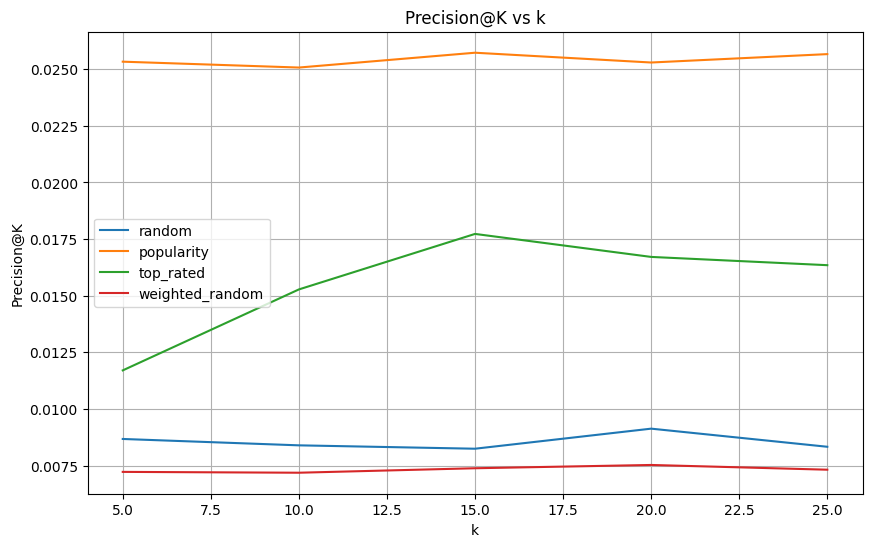

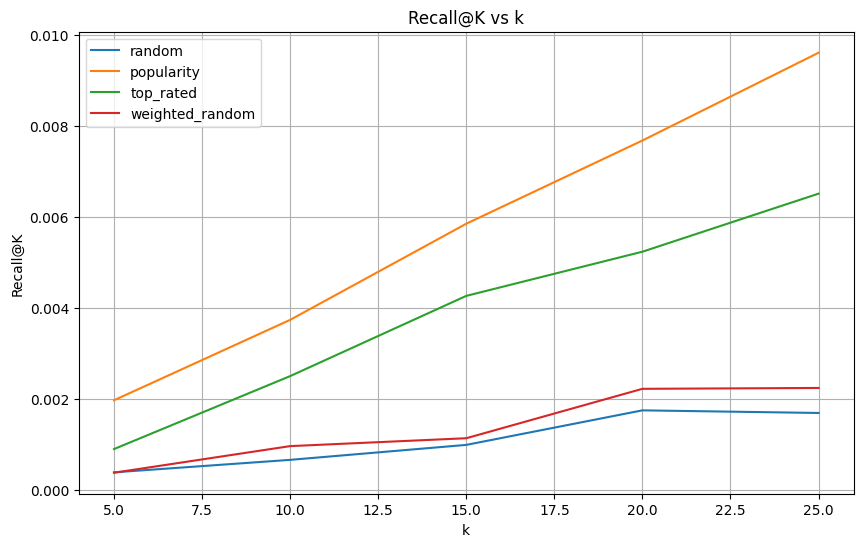

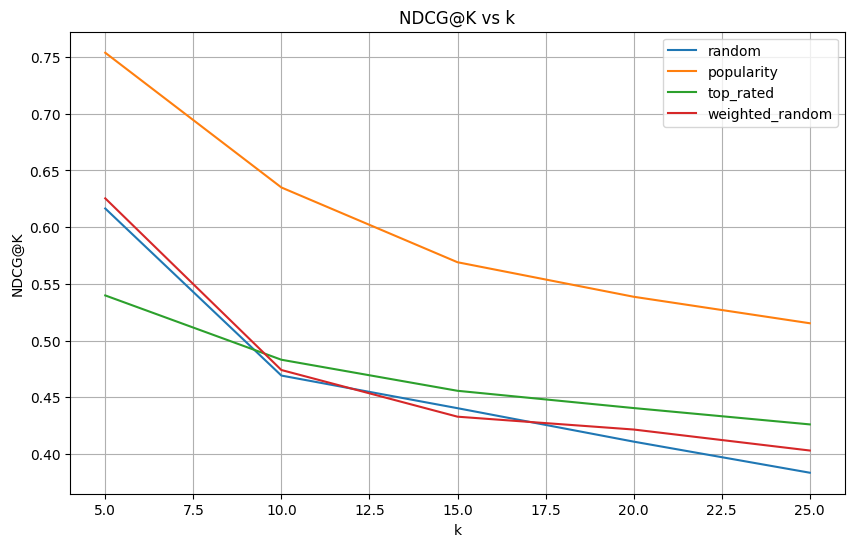

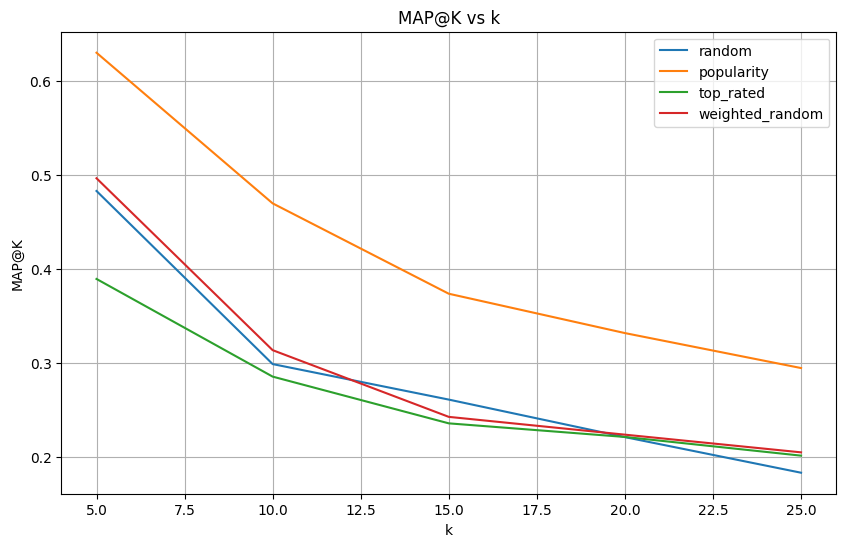

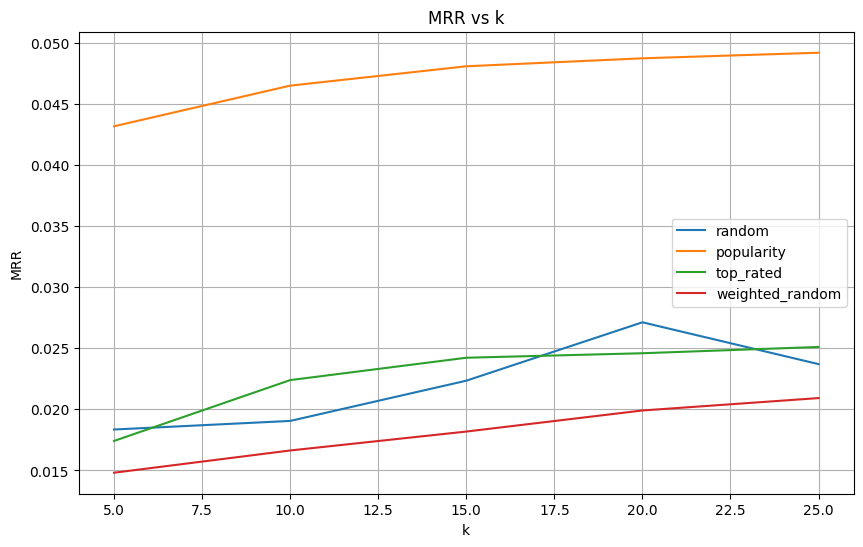

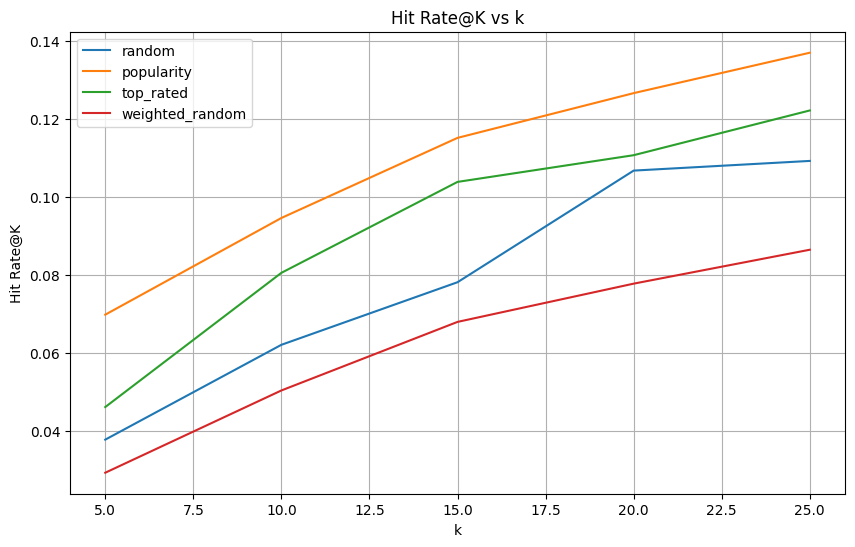

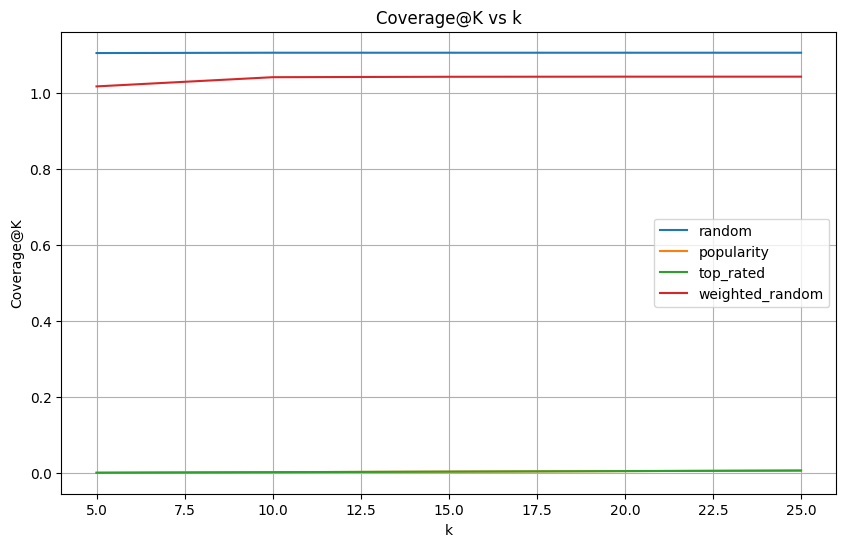

In [68]:
import matplotlib.pyplot as plt

# Function to plot the metrics
def plot_metrics(results, metric_name):
    plt.figure(figsize=(10, 6))
    for recommender in results:
        ks = list(results[recommender].keys())
        metric_values = [results[recommender][k][metric_name] for k in ks]
        plt.plot(ks, metric_values, label=recommender)

    plt.xlabel('k')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} vs k')
    plt.legend()
    plt.grid(True)
    plt.show()

# List of metrics to plot
metrics = ['Precision@K', 'Recall@K', 'NDCG@K', 'MAP@K', 'MRR', 'Hit Rate@K', 'Coverage@K']

# Plot each metric
for metric in metrics:
    plot_metrics(results, metric)
